
##  Volume-variance Relations in Python for Engineers and Geoscientists 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Sequential Indicator Simulation in Python with GSLIB's SGSIM program translated to Python from the original FORTRAN GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

### PGE 383 Exercise: Methods for Spatial Simulation with GeostatsPy

Here's a simple workflow for numerical exploration of volume variance. This method is ciritical for:

* Building spatial models that honor the univariate and spatial distribution of the property of interest 
* While moving between the various scales of data and model cells

WARNING: this workflow using the GSLIB wrapper to make unconditional realizations.  I will replace it shortly, after I have tested unconditional workflows with the reimplementation of SGSIM in GeostatsPy.

#### Dispersion Variance

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_MV_biased.csv available at https://git.io/fhgu0.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.


In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import math

import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

We use GeostatsPy, but we need a new upscale (linear averaging) method and a plotting method that does not interpolate. I will add these to GeostatsPy shortly.

In [2]:
def getindex(nc,cmn,csiz,loc):
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic

def upscale(model,new_nx,new_ny):
    ny, nx = model.shape
    new_xsiz = nx/new_nx; new_xmn = new_xsiz * 0.5
    new_ysiz = ny/new_ny; new_ymn = new_ysiz * 0.5
    new_model = np.zeros((new_ny,new_nx)); count = np.zeros((new_ny,new_nx))
    for iy in range(0,ny):
        yloc = iy+0.5
        new_iy = getindex(new_ny,new_ymn,new_ysiz,yloc)
        for ix in range(0,nx):
            xloc = ix+0.5
            new_ix = getindex(new_nx,new_xmn,new_xsiz,xloc)
            new_model[new_iy,new_ix] = new_model[new_iy,new_ix] + model[iy,ix] 
            count[new_iy,new_ix] = count[new_iy,new_ix] + 1 
    for iny in range(0,new_ny):
        for inx in range(0,new_nx):
            if count[iny,inx] > 0:
                new_model[iny,inx] = new_model[iny,inx] / count[iny,inx]
    return new_model

def cellplt_st(array,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    im = plt.imshow(array,cmap,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20) 


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [3]:
os.chdir("C:/PGE383")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Set the Spatial Parameters

The following are the basic parameters for the experiment.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

In [11]:
nx = 100; ny = 100; cell_size = 100                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size        # calculate the extent of model
cmap = plt.cm.inferno                                             # color map for plotting 
vmin = 0.0; vmax = 0.2                                            # property min and max

#### Numerical Scale Up with Two Models

Let's build two models and scale them up.

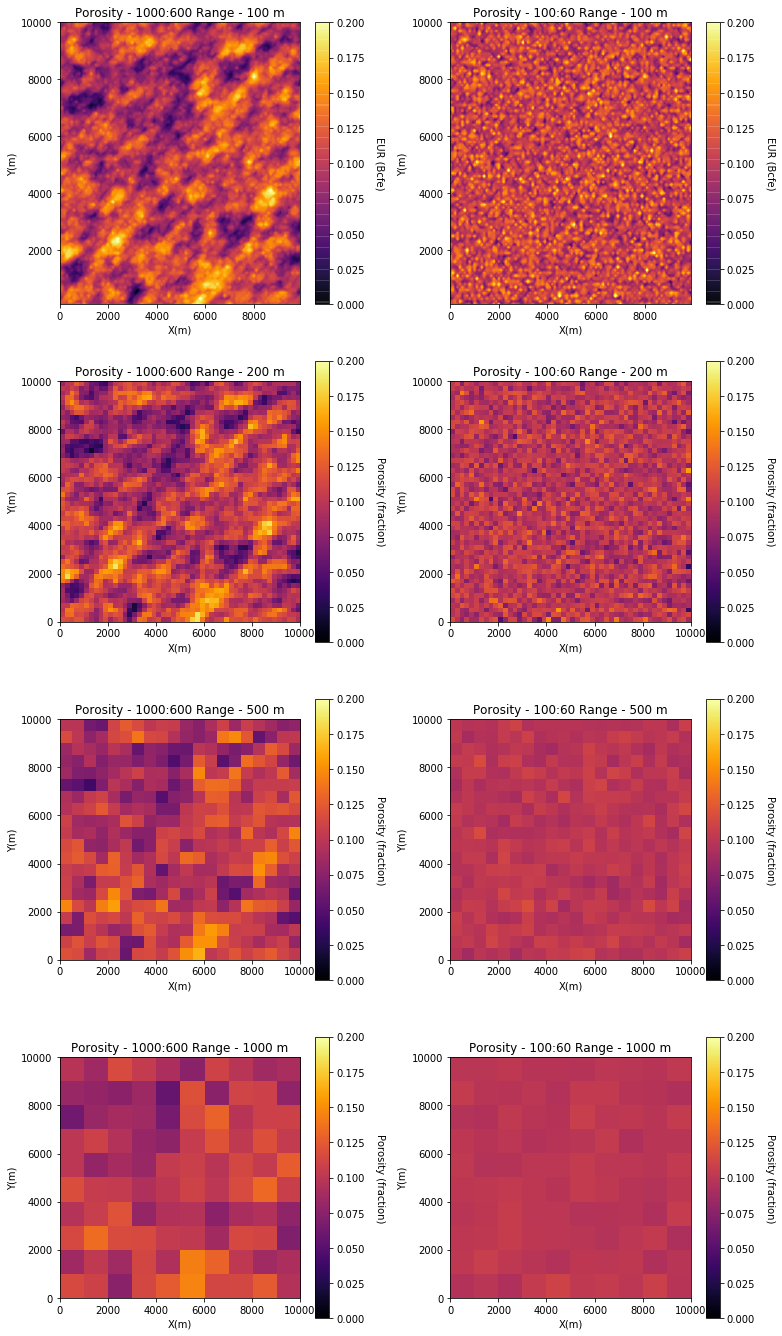

In [12]:

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=1000,hmin1=600)
sim = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario,output_file = "simulation")
sim = GSLIB.affine(sim,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

vario2 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=60)
sim2 = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario2,output_file = "simulation")
sim2 = GSLIB.affine(sim2,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

plt.subplot(421)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 1000:600 Range - 100 m","X(m)","Y(m)","EUR (Bcfe)",cmap)

plt.subplot(422)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 100:60 Range - 100 m","X(m)","Y(m)","EUR (Bcfe)",cmap)

mid = upscale(sim,new_nx = 50,new_ny = 50)
mid2 = upscale(sim2,new_nx = 50,new_ny = 50)

plt.subplot(423)
cellplt_st(mid,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 200 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(424)
cellplt_st(mid2,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 200 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

midb = upscale(sim,new_nx = 20,new_ny = 20)
midb2 = upscale(sim2,new_nx = 20,new_ny = 20)

plt.subplot(425)
cellplt_st(midb,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(426)
cellplt_st(midb2,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

course = upscale(sim,new_nx = 10,new_ny = 10)
course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
cellplt_st(course,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(428)
cellplt_st(course2,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=4.5, wspace=0.3, hspace=0.2)
#plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()

#### Checking the Impact of Scaling on the Distribution

Observe the impact of scaling on the two models. First one with long spatial continuity and then one with short spatial continuity.

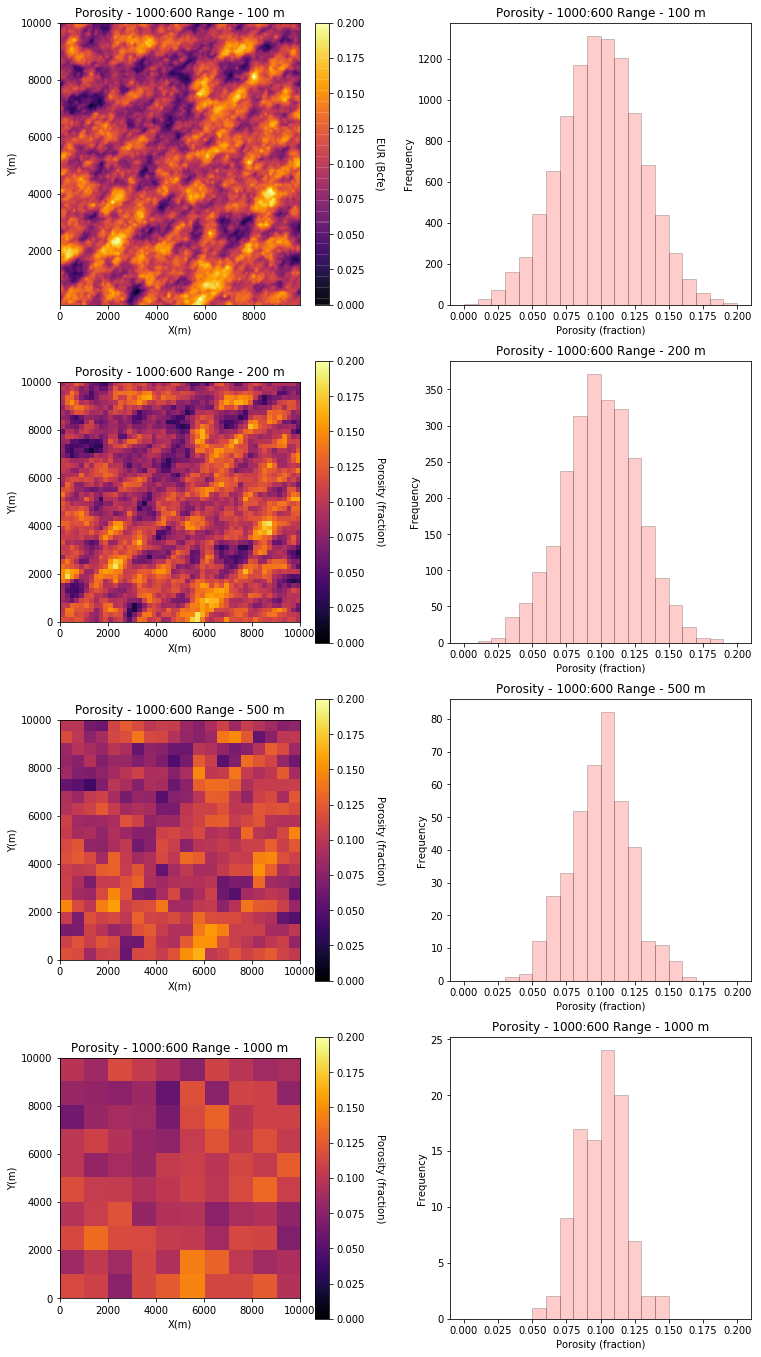

In [14]:
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=1000,hmin1=600)
sim = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario,output_file = "simulation")
sim = GSLIB.affine(sim,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

plt.subplot(421)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 1000:600 Range - 100 m","X(m)","Y(m)","EUR (Bcfe)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:600 Range - 100 m")

mid = upscale(sim,new_nx = 50,new_ny = 50)

plt.subplot(423)
cellplt_st(mid,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 200 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(424)
GSLIB.hist_st(mid.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:600 Range - 200 m")

midb = upscale(sim,new_nx = 20,new_ny = 20)

plt.subplot(425)
cellplt_st(midb,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(426)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:600 Range - 500 m")

course = upscale(sim,new_nx = 10,new_ny = 10)
course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
cellplt_st(course,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 1000:600 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(428)
GSLIB.hist_st(course.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 1000:600 Range - 1000 m")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=4.5, wspace=0.3, hspace=0.2)
#plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()


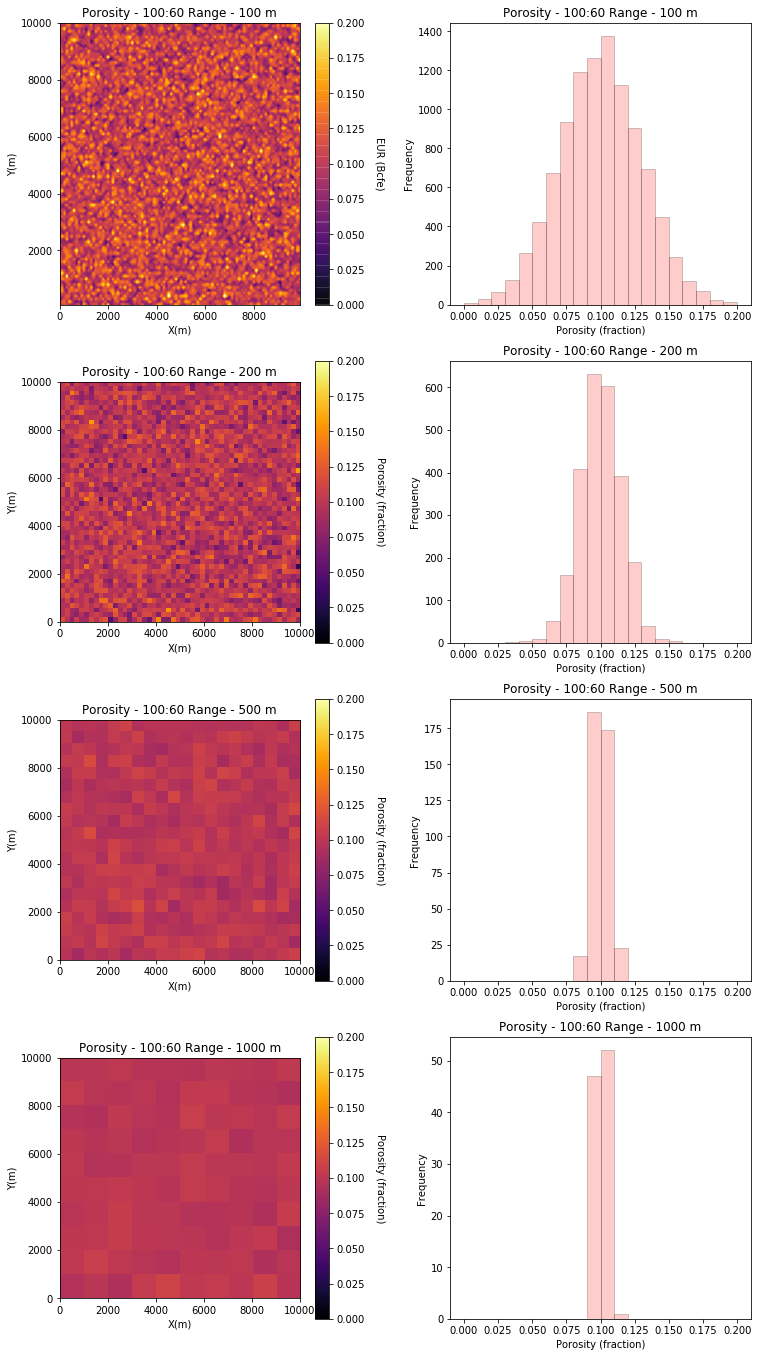

In [15]:

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=60)
sim = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = vario,output_file = "simulation")
sim = GSLIB.affine(sim,.1,0.03)                                     # correct the distribution to a target mean and standard deviation.

plt.subplot(421)
GSLIB.pixelplt_st(sim,xmin,xmax,ymin,ymax,cell_size,0,.2,"Porosity - 100:60 Range - 100 m","X(m)","Y(m)","EUR (Bcfe)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:60 Range - 100 m")

mid = upscale(sim,new_nx = 50,new_ny = 50)

plt.subplot(423)
cellplt_st(mid,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 200 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(424)
GSLIB.hist_st(mid.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:60 Range - 200 m")

midb = upscale(sim,new_nx = 20,new_ny = 20)

plt.subplot(425)
cellplt_st(midb,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 500 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(426)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:60 Range - 500 m")

course = upscale(sim,new_nx = 10,new_ny = 10)
course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
cellplt_st(course,xmin,xmax,ymin,ymax,vmin,vmax,"Porosity - 100:60 Range - 1000 m",'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplot(428)
GSLIB.hist_st(course.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title="Porosity - 100:60 Range - 1000 m")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=4.5, wspace=0.3, hspace=0.2)
#plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()

#### Comments

This was a basic demonstration of scaling with sequential Gaussian simulation truth models. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
